# Code

## Algorithms

In [1]:
import torch
from torch import nn
import copy
import numpy as np
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
from torch import autograd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from collections import defaultdict

In [2]:
class Extragradient(optim.Optimizer):
    def __init__(self, optimizer, params):
        super(Extragradient, self).__init__(params, optimizer.defaults)
        self.params_copy = []
        self.optimizer = optimizer
        self.extrapolation_flag = False

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
            
        if self.extrapolation_flag == False:
            for group in self.param_groups:
                    group["params_copy"] = copy.deepcopy(group["params"])
            self.optimizer.step()
            self.extrapolation_flag = True
        
        else:
            for group in self.param_groups:
                for p, p_copy  in zip(group["params"], group["params_copy"]):
                    p.data = p_copy.data
            self.optimizer.step()
            self.extrapolation_flag = False
        
        return loss

def compute_grad(loss, players):
    grad = []
    for l, p in zip(loss, players):
        grad += list(autograd.grad(l.mean(), p, retain_graph=True, create_graph=True))
    return grad
        
def compute_hamiltonian(grad1, grad2=None):
    if grad2 is None:
        grad2 = grad1
    hamiltonian = 0
    for g1, g2 in zip(grad1, grad2):
        hamiltonian += (g1*g2).sum()
    hamiltonian /= 2

    return hamiltonian
                
class Game(nn.Module):
    def __init__(self):
        super(Game, self).__init__()
        self.players = []
        
    def forward(self, x):
        raise NotImplementedError()
    
    def compute_grad(self, x):
        loss = self.forward(x)
        grad = compute_grad(loss, self.players)
        return grad

    def compute_hamiltonian(self, x1, x2=None):
        loss1 = self.forward(x1)
        grad1 = compute_grad(loss1, self.players)
        
        if x2 is not None:
            loss2 = self.forward(x2)
            grad2 = compute_grad(loss2, self.players)
        else:
            grad2 = None
        
        hamiltonian = compute_hamiltonian(grad1, grad2)
        return hamiltonian
    
    def sample(self):
        raise NotImplentedError()
        
    def compute_metrics(self):
        raise NotImplementedError()
    
class BilinearGame(Game):  
    def __init__(self, dim):
        super(BilinearGame, self).__init__()
        
        self.dim = dim
        self.a = 1./math.sqrt(self.dim)*torch.zeros(self.dim,self.dim).normal_()
        self.b = 1./math.sqrt(self.dim)*torch.zeros(self.dim,self.dim).normal_()
        
        self.matrix = torch.zeros(self.dim, self.dim, self.dim)
        for i in range(self.dim):
            self.matrix[i,i,i] = 1
          
        self.x_star = None
        self.y_star = None
        
        self.reset()    
        
    def reset(self):
        self.players = nn.ParameterList([nn.Parameter(1./math.sqrt(self.dim)*torch.zeros(self.dim).normal_()),
                                         nn.Parameter(1./math.sqrt(self.dim)*torch.zeros(self.dim).normal_())])
             
    def forward(self, index):     
        loss_1 = (self.players[0].view(1,-1)*(self.matrix[index]*self.players[1].view(1, 1, -1)).sum(-1) + self.a[index]*self.players[0].view(1,-1) + 
                  self.b[index]*self.players[1].view(1,-1)).sum(-1)
        loss_2 = -loss_1
        return [loss_1, loss_2]
    
    def solve(self):
        x = np.linalg.solve(self.matrix.mean(0).T,-self.b.mean(0))
        y = np.linalg.solve(self.matrix.mean(0),-self.a.mean(0))
        return torch.tensor(x), torch.tensor(y)
    
    def distance_to_optimum(self):
        if self.x_star is None or self.y_star is None:
            self.x_star, self.y_star = self.solve()
        d = ((self.players[0] - self.x_star)**2).sum().sqrt() + ((self.players[1]-self.y_star)**2).sum().sqrt()
        return d
    
    def sample(self):
        return torch.randint(self.dim, (1,))
    
    def sample_batch(self):
        return torch.arange(DIM)
    
    def compute_metrics(self):
        metrics = {}
        metrics["grad_norm"] = self.compute_hamiltonian(torch.arange(self.dim)).item()
        metrics["distance_to_optimum"] = self.distance_to_optimum().item()
        return metrics
        

In [3]:
# Hamiltonian SGD on bilinear example from (https://arxiv.org/pdf/1904.08598.pdf)
def run_SHGD(game, num_iter=5000, lr=1e0, seed=1234, biased=False, lr_schedule=None, copt = False):
    torch.manual_seed(seed)
    game.reset()
    sgd = optim.SGD(game.parameters(), lr=lr)
    if lr_schedule is not None:
        scheduler = LambdaLR(sgd, lr_schedule)
    else:
        scheduler = LambdaLR(sgd, lambda k: 1.)
    logger = defaultdict(list)
    n_samples = 0
    for i in range(num_iter):
        index1 = game.sample()
        index2 = game.sample()
        batch = game.sample_batch()
        if biased:
            hamiltonian = game.compute_hamiltonian(index1)
        elif copt:
            hamiltonian = game.compute_hamiltonian(torch.cat([index1, index2]))  
        else:
            hamiltonian = game.compute_hamiltonian(index1, index2)
        grad = autograd.grad(hamiltonian, game.parameters())
        for p, g in zip(game.parameters(), grad):
            p.grad = g
        sgd.step()
        scheduler.step()
        n_samples += 2*len(batch)
        
        metrics = game.compute_metrics()
        for key, value in metrics.items():
            logger[key].append(value)
        logger["lr"].append(scheduler.get_lr())
        logger["num_samples"].append(n_samples)
    return logger

In [4]:
# Hamiltonian L-SVRG on bilinear example from (https://arxiv.org/pdf/1904.08598.pdf)
def run_SVRH(game, num_iter=5000, lr=3e1, seed=1234, biased=False, prob=0.01, copt = False):
    torch.manual_seed(seed)
    game.reset()
    game_snapshot = copy.deepcopy(game)
    sgd = optim.SGD(game.parameters(), lr=lr)

    hamiltonian = game_snapshot.compute_hamiltonian(game.sample_batch())
    batch_grad = autograd.grad(hamiltonian, game_snapshot.parameters())

    logger = defaultdict(list)
    n_samples = 0
    for i in range(num_iter):
        index1 = game.sample()
        index2 = game.sample()
        batch = game.sample_batch()

        if biased:
            hamiltonian = game.compute_hamiltonian(index1)
            hamiltonian_snap = game_snapshot.compute_hamiltonian(index1)
        elif copt:
            hamiltonian = game.compute_hamiltonian(torch.cat([index1, index2]))
            hamiltonian_snap = game_snapshot.compute_hamiltonian(torch.cat([index1, index2])) 
        else:
            hamiltonian = game.compute_hamiltonian(index1, index2)
            hamiltonian_snap = game_snapshot.compute_hamiltonian(index1, index2)

        grad = autograd.grad(hamiltonian, game.parameters())  
        grad_snapshot = autograd.grad(hamiltonian_snap, game_snapshot.parameters())

        for p, g, gs, bg in zip(game.parameters(), grad, grad_snapshot, batch_grad):
            p.grad = g - gs + bg
        sgd.step()
        n_samples += 2*len(batch)

        if torch.rand(1) < prob:
            game_snapshot.load_state_dict(game.state_dict())
            hamiltonian = game_snapshot.compute_hamiltonian(game.sample_batch())
            batch_grad = autograd.grad(hamiltonian, game_snapshot.parameters())


        metrics = game.compute_metrics()
        for key, value in metrics.items():
            logger[key].append(value)
        logger["num_samples"].append(n_samples)
    return logger

#log_svrh = run_SVRH(game, NUM_ITER, 5e0, SEED, False, 0.01)
#print(log_svrh["distance_to_optimum"][-1])

In [5]:
def run_SGD(game, num_iter=5000, lr=5e-2, seed=1234, **kwargs):
    #config = Config(dict(mode="sgd", num_iter=num_iter, lr=lr, seed=seed))
    torch.manual_seed(seed)
    game.reset()
    game_avg = copy.deepcopy(game)
    optimizer = optim.SGD(game.parameters(), lr=lr)

    logger = defaultdict(list)
    n_update = 0
    n_samples = 0
    for i in range(num_iter):
        index = game.sample()
        grad = game.compute_grad(index)
        batch = game.sample_batch()
        
        for p, g in zip(game.parameters(), grad):
            p.grad = g
        optimizer.step()
        n_samples += len(batch)

        metrics = game.compute_metrics()
        for key, value in metrics.items():
            logger[key].append(value)

        n_update += 1
        for p, p_avg in zip(game.parameters(), game_avg.parameters()):
            p_avg.data = p/(n_update+1) + p_avg*n_update/(n_update+1)

        metrics = game_avg.compute_metrics()
        for key, value in metrics.items():
            logger[key+":avg"].append(value)
        logger["num_samples"].append(n_samples)
    return logger

In [6]:
def run_COPT(game, num_iter=5000, lr=1e0, seed=1234, biased=False, lr_schedule=None, hamiltonian_coeff=10, copt = False, **kwargs):
    #config = Config(dict(mode="consensus_opt", num_iter=num_iter, lr=lr, seed=seed, hamiltonian_coeff=hamiltonian_coeff))
    torch.manual_seed(seed)
    game.reset()
    sgd = optim.SGD(game.parameters(), lr=lr)
    if lr_schedule is not None:
        lr_schedule = SchedulerLR(lr_schedule)
        scheduler = LambdaLR(sgd, lr_schedule)
    else:
        scheduler = LambdaLR(sgd, lambda k: 1.)
    logger = defaultdict(list)
    n_samples = 0
    for i in range(num_iter):
        index1 = game.sample()
        index2 = game.sample()
        batch = game.sample_batch()
        if biased:
            grad1 = game.compute_grad(index1)
            grad2 = grad1
            hamiltonian = compute_hamiltonian(grad1)
        elif copt:
            grad1 = game.compute_grad(torch.cat([index1, index2]))
            grad2 = grad1
            hamiltonian = compute_hamiltonian(grad1)
        else:
            grad1 = game.compute_grad(index1)
            grad2 = game.compute_grad(index2)
            hamiltonian = compute_hamiltonian(grad1, grad2)
        grad_H = autograd.grad(hamiltonian, game.parameters())
        for p, g1, g2, gH in zip(game.parameters(), grad1, grad2, grad_H):
            p.grad = 0.5*(g1+g2) + hamiltonian_coeff*gH
        sgd.step()
        scheduler.step()
        n_samples += 2*len(batch)
        
        metrics = game.compute_metrics()
        for key, value in metrics.items():
            logger[key].append(value)
        #logger["lr"].append(scheduler.get_last_lr())
        logger["num_samples"].append(n_samples)
    return logger

In [7]:
def run_restartSVRH(game, num_iter=5000, lr=0.2, seed=1234, save_params=False, biased=False, prob=0.01, restart=100, copt = False, **kwargs):
    #config = Config(dict(mode="restart-svrh", num_iter=num_iter, lr=lr, seed=seed, biased=biased, prob=prob))
    torch.manual_seed(seed)
    game.reset()
    game_snapshot = copy.deepcopy(game)
    sgd = optim.SGD(game.parameters(), lr=lr)

    logger = defaultdict(list)

    players_history = [game.state_dict()]
    params_history = []
    n_samples = 0
    for i in range(num_iter):
        if i%restart == 0:
            state_dict = np.random.choice(players_history)
            game.load_state_dict(state_dict)
            game_snapshot.load_state_dict(state_dict)

            batch = game.sample_batch()
            hamiltonian = game_snapshot.compute_hamiltonian(batch)
            batch_grad = autograd.grad(hamiltonian, game_snapshot.parameters()) 
            n_samples += 2*len(batch)
            players_history = [state_dict]


        index1 = game.sample()
        index2 = game.sample()

        if biased:
            hamiltonian = game.compute_hamiltonian(index1)
            hamiltonian_snap = game_snapshot.compute_hamiltonian(index1)
            n_samples += 2*len(batch)

        else:
            hamiltonian = game.compute_hamiltonian(index1, index2)
            hamiltonian_snap = game_snapshot.compute_hamiltonian(index1, index2)
            n_samples += 4*len(batch)

        grad = autograd.grad(hamiltonian, game.parameters())  
        grad_snapshot = autograd.grad(hamiltonian_snap, game_snapshot.parameters())

        for p, g, gs, bg in zip(game.parameters(), grad, grad_snapshot, batch_grad):
            p.grad = g - gs + bg
        sgd.step()

        players_history.append(copy.deepcopy(game.state_dict()))

        if torch.rand(1) < prob:
            game_snapshot.load_state_dict(game.state_dict())
            batch = game.sample_batch()
            hamiltonian = game_snapshot.compute_hamiltonian(batch)
            batch_grad = autograd.grad(hamiltonian, game_snapshot.parameters())
            n_samples += len(batch)**2/2

        metrics = game.compute_metrics()
        for key, value in metrics.items():
            logger[key].append(value)
        logger["num_samples"].append(n_samples)

        if save_params:
            params_history.append(copy.deepcopy(game.state_dict()))

    logger["params"] = params_history
    return logger

## GANs

In [8]:
class NormalGAN(Game):  
    def __init__(self, dim, batch_size = 1, real_mu = 0, real_sigma = 1, ns = False):
        super(NormalGAN, self).__init__()
        
        self.dim = dim
        self.z = torch.zeros(self.dim).normal_(0,1)
        self.real = torch.zeros(self.dim).normal_(real_mu, real_sigma)
        self.y = torch.FloatTensor(batch_size).fill_(1)
        self.y2 = torch.FloatTensor(batch_size).fill_(0)
        self.real_mu = real_mu
        self.real_sigma = real_sigma
        self.ns = ns
        self.batch_size = batch_size
          
        self.x_star = None
        self.y_star = None
        
        self.reset()    
        
    def reset(self):
      # to fix to initial values
        self.players = nn.ParameterList([nn.Parameter(torch.zeros(2).uniform_(-1,1)),
                                         nn.Parameter(torch.zeros(3).uniform_(-1,1))])
             
    def forward(self, index):     
        BCE_stable = torch.nn.BCEWithLogitsLoss()
        
        real = self.real[index]
        fake = self.players[0][0] + self.players[0][1]*self.z[index]
        D_real = self.players[1][0] + self.players[1][1]*real + self.players[1][2]*real*real
        D_fake = self.players[1][0] + self.players[1][1]*fake + self.players[1][2]*fake*fake
        self.y.resize_as_(D_real).fill_(1)
        self.y2.resize_as_(D_fake).fill_(0)
        loss_D = BCE_stable(D_real,self.y)+BCE_stable(D_fake,self.y2)
        if self.ns:
          loss_G = BCE_stable(D_fake,self.y)+BCE_stable(D_real,self.y2)
        else:
          loss_G = -loss_D
        return [loss_G, loss_D]
    
    def distance_to_optimum(self):
        # Although true distance is to self.real_mu, its better to use average from whole dataset 
        # d = ((self.players[0][0] - self.real_mu)**2).sum().sqrt() + ((self.players[0][1] - self.real_sigma)**2).sum().sqrt()
        d = ((self.players[0][0] - torch.mean(self.real))**2).sum().sqrt() + ((torch.abs(self.players[0][1]) - torch.std(self.real))**2).sum().sqrt()
        return d
    
    def sample(self):
        return torch.randint(self.dim, (self.batch_size,))
    
    def sample_batch(self):
        return torch.arange(self.dim)
    
    def compute_metrics(self):
        metrics = {}
        metrics["grad_norm"] = self.compute_hamiltonian(torch.arange(self.dim)).item()
        metrics["distance_to_optimum"] = self.distance_to_optimum().item()
        #metrics["G"] = self.players[0].data
        #metrics["D"] = self.players[1].data
        return metrics

class NormalGAN_init(Game):  
    def __init__(self, dim, batch_size=1, real_mu = 0, real_sigma = 1, ns = False, init_D = [0.5,0.5,0.5], init_G = [0.5,0.5]):
        super(NormalGAN_init, self).__init__()
        
        self.dim = dim
        self.z = torch.zeros(self.dim).normal_(0,1)
        self.real = torch.zeros(self.dim).normal_(real_mu, real_sigma)
        self.y = torch.FloatTensor(self.dim).fill_(1)
        self.y2 = torch.FloatTensor(self.dim).fill_(0)
        self.real_mu = real_mu
        self.real_sigma = real_sigma
        self.init_D = init_D
        self.init_G = init_G
        self.ns = ns
        self.batch_size = batch_size
          
        self.x_star = None
        self.y_star = None
        
        self.reset()    
        
    def reset(self):
      # to fix to initial values
        self.players = nn.ParameterList([nn.Parameter(torch.FloatTensor(self.init_G)),
                                         nn.Parameter(torch.FloatTensor(self.init_D))])
                                         
    def forward(self, index):     
        BCE_stable = torch.nn.BCEWithLogitsLoss()
        
        real = self.real[index]
        fake = self.players[0][0] + self.players[0][1]*self.z[index]
        D_real = self.players[1][0] + self.players[1][1]*real + self.players[1][2]*real*real
        D_fake = self.players[1][0] + self.players[1][1]*fake + self.players[1][2]*fake*fake
        self.y.resize_as_(D_real).fill_(1)
        self.y2.resize_as_(D_fake).fill_(0)
        loss_D = BCE_stable(D_real,self.y)+BCE_stable(D_fake,self.y2)
        if self.ns:
          loss_G = BCE_stable(D_fake,self.y)+BCE_stable(D_real,self.y2)
        else:
          loss_G = -loss_D
        return [loss_G, loss_D]

    def distance_to_optimum(self):
        # Although true distance is to self.real_mu, its better to use average from whole dataset 
        # d = ((self.players[0][0] - self.real_mu)**2).sum().sqrt() + ((self.players[0][1] - self.real_sigma)**2).sum().sqrt()
        d = ((self.players[0][0] - torch.mean(self.real))**2).sum().sqrt() + ((torch.abs(self.players[0][1]) - torch.std(self.real))**2).sum().sqrt()
        return d
    
    def sample(self):
        return torch.randint(self.dim, (self.batch_size,))
    
    def sample_batch(self):
        return torch.arange(self.dim)
    
    def compute_metrics(self):
        metrics = {}
        metrics["grad_norm"] = self.compute_hamiltonian(torch.arange(self.dim)).item()
        metrics["distance_to_optimum"] = self.distance_to_optimum().item()
        #metrics["G"] = copy.deepcopy(self.players[0].data)
        #metrics["D"] = copy.deepcopy(self.players[1].data)
        return metrics

class WGAN_init(Game):  
    def __init__(self, dim, batch_size=1, real_mu = 0, real_sigma = 1, ns = False, init_D = [0.5,0.5], init_G = [0.5,0.5]):
        super(WGAN_init, self).__init__()
        
        self.dim = dim
        self.z = torch.zeros(self.dim).normal_(0,1)
        self.real = torch.zeros(self.dim).normal_(real_mu, real_sigma)
        self.real_mu = real_mu
        self.real_sigma = real_sigma
        self.init_D = init_D
        self.init_G = init_G
        self.ns = ns
        self.batch_size = batch_size
          
        self.x_star = None
        self.y_star = None
        
        self.reset()    
        
    def reset(self):
      # to fix to initial values
        self.players = nn.ParameterList([nn.Parameter(torch.FloatTensor(self.init_G)),
                                         nn.Parameter(torch.FloatTensor(self.init_D))])
                                         
    def forward(self, index):     
        BCE_stable = torch.nn.BCEWithLogitsLoss()
        
        real = self.real[index]
        fake = self.players[0][0] + self.players[0][1]*self.z[index]
        D_real = self.players[1][0]*real + self.players[1][1]*real*real
        D_fake = self.players[1][0]*fake + self.players[1][1]*fake*fake
        loss_D = -(D_real - D_fake)
        loss_G = -loss_D
        return [loss_G, loss_D]

    def distance_to_optimum(self):
        # Although true distance is to self.real_mu, its better to use average from whole dataset 
        # d = ((self.players[0][0] - self.real_mu)**2).sum().sqrt() + ((self.players[0][1] - self.real_sigma)**2).sum().sqrt()
        d = ((self.players[0][0] - torch.mean(self.real))**2).sum().sqrt() + ((torch.abs(self.players[0][1]) - torch.std(self.real))**2).sum().sqrt()
        return d
    
    def sample(self):
        return torch.randint(self.dim, (self.batch_size,))
    
    def sample_batch(self):
        return torch.arange(self.dim)
    
    def compute_metrics(self):
        metrics = {}
        metrics["grad_norm"] = self.compute_hamiltonian(torch.arange(self.dim)).item()
        metrics["distance_to_optimum"] = self.distance_to_optimum().item()
        #metrics["G"] = copy.deepcopy(self.players[0].data)
        #metrics["D"] = copy.deepcopy(self.players[1].data)
        return metrics

class WGAN(Game):  
    def __init__(self, dim, batch_size=1, real_mu = 0, real_sigma = 1, ns = False):
        super(WGAN, self).__init__()
        
        self.dim = dim
        self.z = torch.zeros(self.dim).normal_(0,1)
        self.real = torch.zeros(self.dim).normal_(real_mu, real_sigma)
        self.real_mu = real_mu
        self.real_sigma = real_sigma
        self.ns = ns
        self.batch_size = batch_size
          
        self.x_star = None
        self.y_star = None
        
        self.reset()    
        
    def reset(self):
      # to fix to initial values
        self.players = nn.ParameterList([nn.Parameter(torch.zeros(2).uniform_(-1,1)),
                                         nn.Parameter(torch.zeros(3).uniform_(-1,1))])
                                         
    def forward(self, index):     
        BCE_stable = torch.nn.BCEWithLogitsLoss()
        
        real = self.real[index]
        fake = self.players[0][0] + self.players[0][1]*self.z[index]
        D_real = self.players[1][0]*real + self.players[1][1]*real*real
        D_fake = self.players[1][0]*fake + self.players[1][1]*fake*fake
        loss_D = -(D_real - D_fake)
        loss_G = -loss_D
        return [loss_G, loss_D]

    def distance_to_optimum(self):
        # Although true distance is to self.real_mu, its better to use average from whole dataset 
        # d = ((self.players[0][0] - self.real_mu)**2).sum().sqrt() + ((self.players[0][1] - self.real_sigma)**2).sum().sqrt()
        d = ((self.players[0][0] - torch.mean(self.real))**2).sum().sqrt() + ((torch.abs(self.players[0][1]) - torch.std(self.real))**2).sum().sqrt()
        return d
    
    def sample(self):
        return torch.randint(self.dim, (self.batch_size,))
    
    def sample_batch(self):
        return torch.arange(self.dim)
    
    def compute_metrics(self):
        metrics = {}
        metrics["grad_norm"] = self.compute_hamiltonian(torch.arange(self.dim)).item()
        metrics["distance_to_optimum"] = self.distance_to_optimum().item()
        #metrics["G"] = copy.deepcopy(self.players[0].data)
        #metrics["D"] = copy.deepcopy(self.players[1].data)
        return metrics

In [9]:
def lr_schedule(k, epoch=500):
    if k <= epoch:
        gamma = 1
    else:
        gamma = (epoch/2)*(2*k+1)/(k+1)**2
    return gamma

# Experiments leading to the plots

In [39]:
col = {"CO":"dodgerblue", "SGDA":"mediumaquamarine", "SHGD (constant step-size)":"tab:orange", "L-SVRHG":"tab:purple"} # Color scheme
list_markers = {"CO":"*", "SGDA":"o", "SHGD (constant step-size)":"s", "L-SVRHG":">"}

In [11]:
%ls

GAN.ipynb                     stochastic_hamiltonian.ipynb
plot_bilinear.ipynb


In [12]:
!mkdir plots

In [13]:
%cd ./plots

/Users/hberard/Documents/facebook_code/stochastic-hamiltonian/notebook/plots


In [14]:
plt.rcParams.update({'font.size': 12})
#plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
#params = {'text.usetex': True,
#         'font.size': 12,
#         'font.family': 'lmodern',
#         'text.latex.unicode': True,
#         }
#plt.rcParams.update(params)

## Batch size = 100

In [15]:
## WGAN

DIM = 10000
NUM_ITER = 2000
BATCHSIZE = 100
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_wgan = WGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_wgan_2 = WGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_wgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_wgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_wgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_wgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_wgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

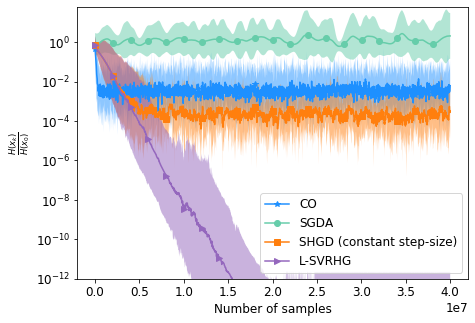

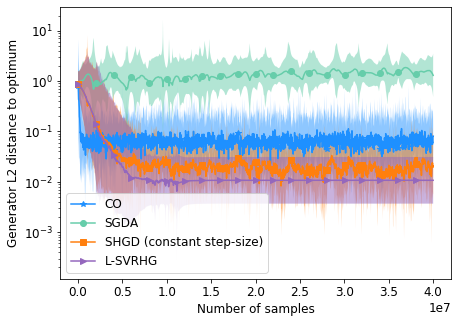

In [55]:
scale = 2
for key, value in logs_wgan.items():

  plt.rcParams["figure.figsize"] = (7,5)

  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("wgan_Ham_batch100.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("wgan_batch100.pdf")

In [17]:
## saturating GAN

DIM = 10000
#SEED = 2
NUM_ITER = 2000
BATCHSIZE = 100
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_sgan = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_sgan_2 = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_sgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_sgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_sgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_sgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_sgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

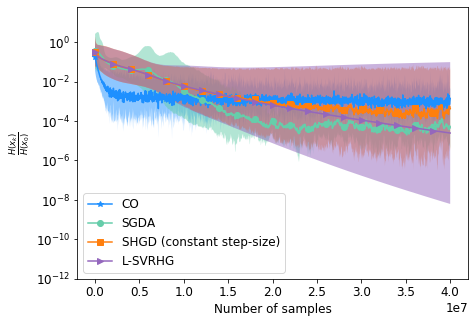

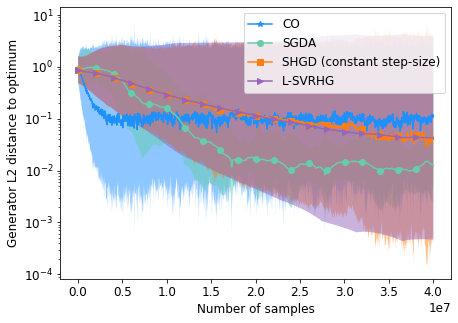

In [56]:
scale = 2
for key, value in logs_sgan.items():

  plt.rcParams["figure.figsize"] = (7,5)

  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("satgan_Ham_batch100.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("satgan_batch100.pdf")

In [19]:
## non-saturating GAN

DIM = 10000
NUM_ITER = 2000
BATCHSIZE = 100
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_nonsatgan = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_nonsatgan_2 = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_nonsatgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_nonsatgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_nonsatgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_nonsatgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_nsgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

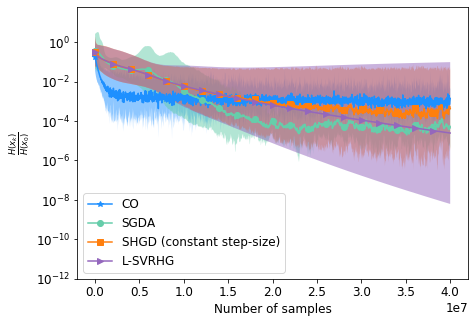

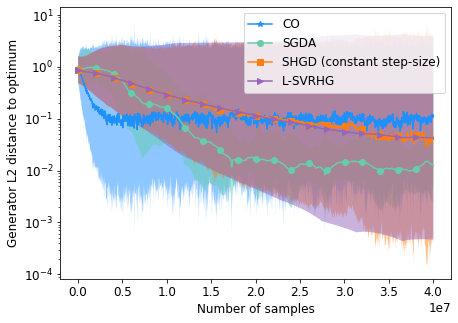

In [57]:
scale = 2
for key, value in logs_nsgan.items():

  plt.rcParams["figure.figsize"] = (7,5)

  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("nonsatgan_Ham_batch100.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("nonsatgan_batch100.pdf")

## Batch size = Full

In [21]:
## WGAN

DIM = 10000
NUM_ITER = 2000
BATCHSIZE = 10000
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_wgan = WGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_wgan_2 = WGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_wgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_wgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_wgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_wgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_full_wgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

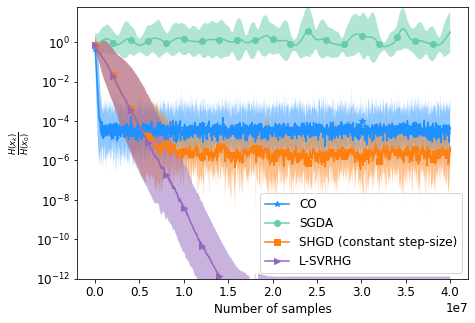

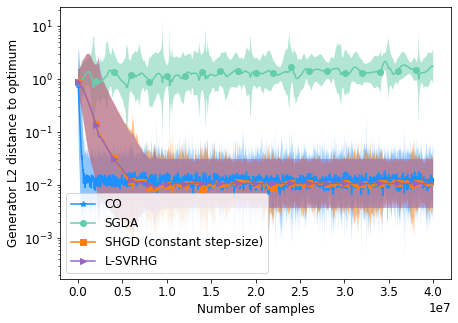

In [58]:
scale = 2
for key, value in logs_full_wgan.items():

  plt.rcParams["figure.figsize"] = (7,5)
  
  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("wgan_Ham_fullbatch.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("wgan_fullbatch.pdf")

In [23]:
## saturating GAN

DIM = 10000
NUM_ITER = 2000
BATCHSIZE = 10000
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_sgan = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_sgan_2 = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_sgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_sgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_sgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_sgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_full_sgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

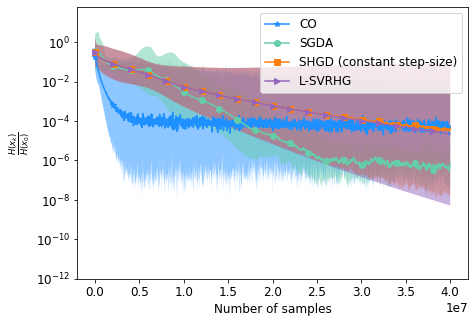

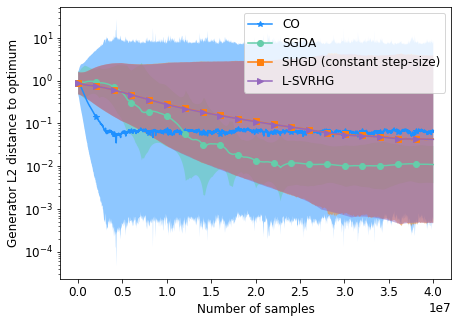

In [59]:
scale = 2
for key, value in logs_full_sgan.items():

  plt.rcParams["figure.figsize"] = (7,5)

  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("satgan_Ham_fullbatch.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("satgan_fullbatch.pdf")

In [25]:
## non-saturating GAN

DIM = 10000
NUM_ITER = 2000
BATCHSIZE = 10000
N_seed = 10
scale = 2

log_shgd = [[None]* N_seed, [None]* N_seed]
log_sgd = [[None]* N_seed, [None]* N_seed]
log_cons_bias = [[None]* N_seed, [None]* N_seed]
log_svrh = [[None]* N_seed, [None]* N_seed]

for i in range(N_seed):
  SEED = i+1

  torch.manual_seed(SEED)
  game_nonsatgan = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE)
  torch.manual_seed(SEED)
  game_nonsatgan_2 = NormalGAN(DIM, ns=False, batch_size=BATCHSIZE*2)

  fit = run_SHGD(game_nonsatgan, NUM_ITER, 2e-2, SEED, False)
  log_shgd[0][i] = fit["grad_norm"]
  log_shgd[1][i] = fit["distance_to_optimum"]
  fit = run_SGD(game_nonsatgan_2, NUM_ITER, 2e-2, SEED)
  log_sgd[0][i] = fit["grad_norm"]
  log_sgd[1][i] = fit["distance_to_optimum"]
  fit = run_COPT(game_nonsatgan, NUM_ITER, 2e-2, SEED, copt=True)
  log_cons_bias[0][i] = fit["grad_norm"]
  log_cons_bias[1][i] = fit["distance_to_optimum"]
  fit = run_SVRH(game_nonsatgan, NUM_ITER, 2e-2, SEED, False, prob=1/100)
  log_svrh[0][i] = fit["grad_norm"]
  log_svrh[1][i] = fit["distance_to_optimum"]

logs_full_nsgan = {"CO":log_cons_bias, "SGDA":log_sgd, "SHGD (constant step-size)":log_shgd, "L-SVRHG":log_svrh}

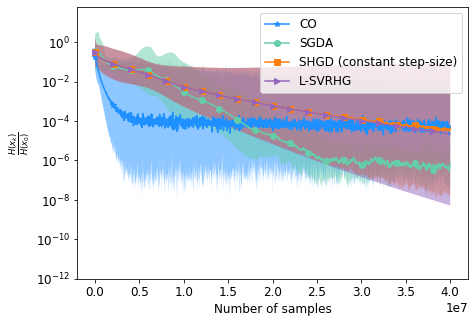

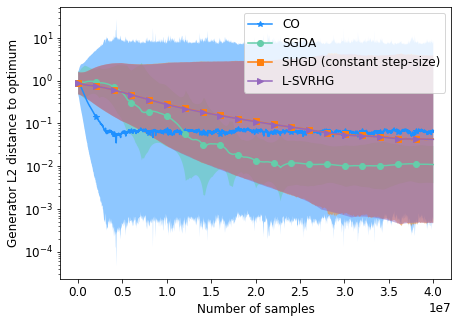

In [60]:
scale = 2
for key, value in logs_full_nsgan.items():

  plt.rcParams["figure.figsize"] = (7,5)

  plt.figure(1)  # create a figure object
  plt.yscale("log")
  plt.ylim(10e-13, 60e0)
  mean = np.mean(value[0],0)
  std = np.std(value[0],0)
  mean_log = np.mean(np.log10(value[0]),0)
  std_log = np.std(np.log10(value[0]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])
  plt.xlabel("Number of samples")
  plt.ylabel(r"$\frac{H(x_k)}{H(x_0)}$")
  plt.legend()
  plt.savefig("nonsatgan_Ham_fullbatch.pdf")

  plt.figure(2)
  plt.yscale("log")
  mean_log = np.mean(np.log10(value[1]),0)
  std_log = np.std(np.log10(value[1]), 0)
  plt.plot(fit["num_samples"], np.power(10,mean_log), label=key, color=col[key], marker=list_markers[key], markevery=100)
  plt.fill_between(fit["num_samples"], np.power(10,mean_log-scale*std_log) , np.power(10,mean_log+scale*std_log), alpha=0.5, fc=col[key])

  plt.xlabel("Number of samples")
  plt.ylabel("Generator L2 distance to optimum")
  plt.legend()
  plt.savefig("nonsatgan_fullbatch.pdf")

## Saving plots to computer

In [27]:
from google.colab import files
!zip -r /content/file_new.zip /content/plots

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
files.download( "/content/file_new.zip")